In [1]:
from training_cmdline import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np

2023-08-30 17:00:35.049898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 17:00:48.822988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sathlerar/data/conda/lib:/usr/local/CUDA/11.3.0/bin:/usr/local/CUDA/11.3.0/targets/x86_64-linux/lib:/usr/local/cuDNN/8.2.1/CUDA-11.3/lib64:/usr/bin
2023-08-30 17:00:48.823217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or dire

In [2]:
def gen_rand_ones(shape):
    rand = tf.random.uniform(shape = shape)
    gIdx = tf.where(tf.math.greater_equal(rand, 0.5))
    lIdx = tf.where(tf.math.less(rand, 0.5))
    rand = tf.tensor_scatter_nd_update(rand, gIdx, tf.ones(shape=gIdx.shape[0]))
    rand = tf.tensor_scatter_nd_update(rand, lIdx, tf.zeros(shape=lIdx.shape[0]))
    return tf.cast(rand, 'float32')

In [3]:
ones = gen_rand_ones((4, 3)).numpy()

2023-08-30 17:01:19.636655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15389 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0d:00.0, compute capability: 6.0


In [4]:
ones

array([[0., 0., 1.],
       [0., 1., 1.],
       [1., 1., 1.],
       [0., 0., 0.]], dtype=float32)

In [5]:
np.where(ones == 1)

(array([0, 1, 1, 2, 2, 2]), array([2, 1, 2, 0, 1, 2]))

In [6]:
import os
J_ROOT = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
npzpath = os.path.join(J_ROOT, "annotated_datasets/23-08-29_32x32_cNp_erdi_nNorm/npz/data.npz")

In [7]:
train_dict, (xtest, ytest) = get_data_sample(npzpath)
train_dict['labels'] = to_categorical(train_dict['labels'], 3)
ytest = to_categorical(ytest, 3)

/gpfs/gsfs8/users/sathlerar/conda/envs/pecot/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
train_dict['labels'][0]

array([1., 0., 0.], dtype=float32)

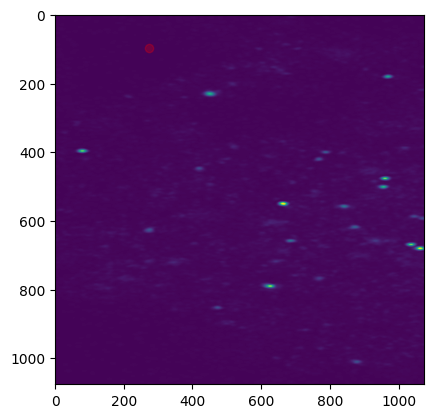

In [9]:
from matplotlib import pyplot as plt
plt.imshow(train_dict['channels'][0,:,:,0])
x, y = [train_dict['pixels_x'][0]], [train_dict['pixels_y'][0]]
plt.scatter(x, y, c='r', alpha = 0.25)

In [10]:
train_dict['channels'].shape

(144, 1076, 1076, 1)

In [55]:
ch_temp = train_dict['channels']

In [58]:
ch_temp[np.isnan(ch_temp)]

array([], dtype=float32)

In [11]:
def this_gen(img, img_ind, x_coords, y_coords, y_init, batch_size, n_channels, n_classes, win_x, win_y, augmentation = True):

    cpt = 0

    n_images = len(img_ind)
    arr = np.arange(n_images)
    np.random.shuffle(arr)

    while(True):

        # buffers for a batch of data - CHANGED ARS 06/07/2023
        batch_x = np.zeros(tuple([batch_size] + [2*win_x+1, 2*win_y+1] + [n_channels]))
        batch_y = np.zeros(tuple([batch_size] + [n_classes]))
        # get one image at a time
        for k in range(batch_size):

            # get random image
            img_index = arr[cpt%len(img_ind)]

            # open images
            patch_x = img[img_ind[img_index], (x_coords[img_index]-win_x):(x_coords[img_index]+win_x+1), (y_coords[img_index]-win_y):(y_coords[img_index]+win_y+1), :]
            patch_x = np.asarray(patch_x)
            current_class = np.asarray(y_init[img_index])
            current_class = current_class.astype('float32')

            if augmentation:
                augmentationMap = GenerateRandomImgaugAugmentation()
                patch_x = augmentationMap(image=patch_x)


            # save image to buffer
            batch_x[k, :, :, :] = patch_x.astype('float32')
            batch_y[k, :] = current_class
            cpt += 1

        # return the buffer
        return batch_x, batch_y

In [39]:
x, y = this_gen(
    train_dict['channels'], train_dict['batch'], train_dict['pixels_x'],
    train_dict['pixels_y'], train_dict['labels'], 3, 1, 3, train_dict['win_x'], 
    train_dict['win_y'])

In [40]:
x, y = x.astype('float32'), y.astype('float32')

In [41]:
y_true = gen_rand_ones(shape=(3,3))

In [47]:
y = np.array([[None, None, None], [None, None, None], [None, None, None]], dtype='float32')

In [48]:
print(y_true, y, sep = '\n')

tf.Tensor(
[[1. 1. 1.]
 [0. 1. 1.]
 [1. 0. 1.]], shape=(3, 3), dtype=float32)
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]


In [49]:
K.set_floatx('float32')

In [50]:
weights = [66, 66, 1]
weights2 = tf.constant([np.float32(x) / np.sum(weights) for x in weights], dtype='float32')
print(weights2)

tf.Tensor([0.49624062 0.49624062 0.0075188 ], shape=(3,), dtype=float32)


In [51]:
# zIdx = tf.where(tf.math.equal(y, 0))
# iIdx = tf.where(tf.math.equal(y, 1))
# y = tf.tensor_scatter_nd_update(y, zIdx, tf.constant(float(0.00001), shape=zIdx.shape[0]))
# y = tf.tensor_scatter_nd_update(y, iIdx, tf.constant(float(0.99999), shape=iIdx.shape[0]))
loss = y_true * tf.math.log(y)
loss *= weights2
print(loss)

tf.Tensor(
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]], shape=(3, 3), dtype=float32)


In [52]:
tf.convert_to_tensor(-K.sum(loss, -1))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>